In [1]:
import sys

sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")

my_modules = ['plot_functions', 'load_model_output', 
               'plot_3D_functions']
for mod in my_modules:
    if mod in sys.modules:
        print (mod)
        del sys.modules[mod]

import ipywidgets as widgets

from load_model_output import *
from plot_functions import *
from plot_3D_functions import *



In [2]:
dirs = os.listdir(os.path.join(project_dir , 'model_output/'))
dirs = list(set(dirs) - {'.DS_Store'})
dirs.sort()
dirs = [d for d in dirs if 'inflow' in d]
select_base_name = widgets.Dropdown(
    options=dirs,
    description='base_name:',
    disabled=False,
)
select_base_name

Dropdown(description='base_name:', options=('test_inflow', 'test_inflow_dt', 'test_inflow_dx'), value='test_in…

In [3]:
base_name = select_base_name.value
base_dir = os.path.join(project_dir, 'model_output', base_name )
print(base_name)
print_input_params(base_dir)

test_inflow
batch:
	tr : 10
sim:
	q1_m2hr : 0.5, 1.0, 2.0, 3.0
	So : 0.01, 0.1
common:
	H_i : 0.0


In [4]:
core = load_sims(base_dir)
name_vars=   get_name_vars(base_dir)
core = add_pretty_name(core, name_vars)

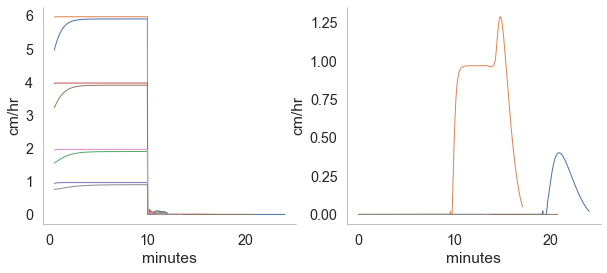

In [5]:
# plot all
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
fig = plot_inflowgraphs(core, trim = 30, nonzero = True, ax= axes[0])
fig = plot_hydrographs(core, nonzero = True, ax = axes[1])


No handles with labels found to put in legend.


(<Figure size 1152x360 with 8 Axes>, <Figure size 1152x360 with 8 Axes>)

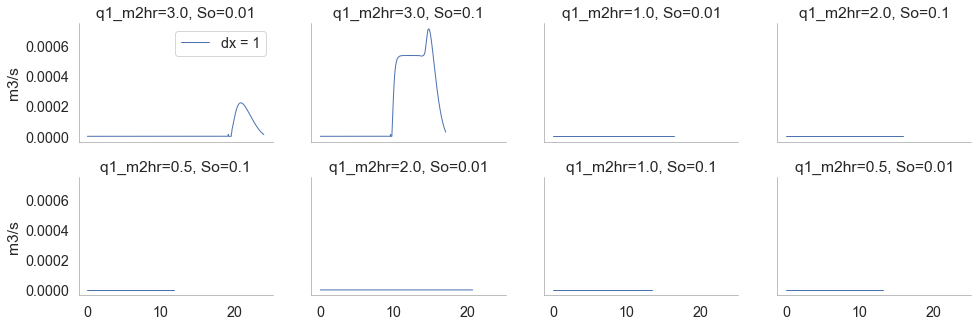

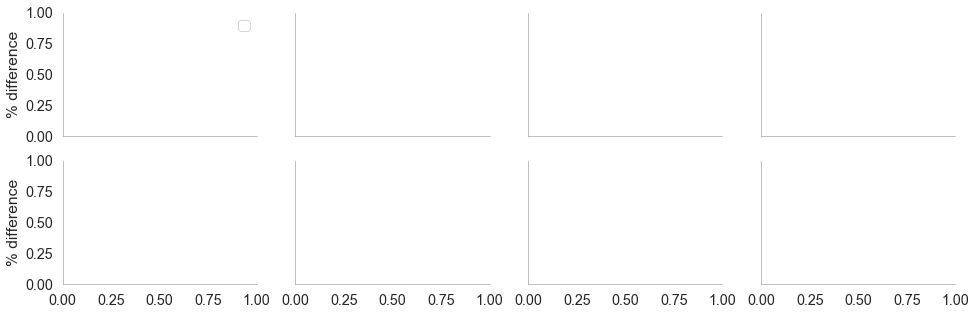

In [6]:
plot_matched_hydrographs(core, "dx")

In [7]:
def summarize_inflow(core):
    core = core.sort_values(["q1_m2hr", "So"], ascending = True)
    
    summary = pd.DataFrame(index = core.index)

    for i,key in enumerate(core.index):
        sim = core.loc[key]
        # input flux m2/s
        q1 = sim.q1

        rain = sim.rain
        f = sim.ksatV

        # Use mass balance to determine how far the wetting front will get
        if sim.ksatV > 0:
            L_max = q1/(sim.ksatV)
        else:
            L_max = np.inf

        summary.loc[key, "L_max"] = L_max

        x_front, t_front = compute_front(sim)
        
        summary.loc[key, "t_10m"] = t_front[int(10/sim.dx)]

        summary.loc[key, "t_20m"] = t_front[int(20/sim.dx)]

        summary.loc[key, "t_end"] = t_front[-1]
        
    
    return summary

summarize_inflow(core)

,L_max,t_10m,t_20m,t_end
"tr-10/So-0.01,q1_m2hr-0.5/",10.0,inf,inf,inf
"tr-10/So-0.1,q1_m2hr-0.5/",10.0,inf,inf,inf
"tr-10/So-0.01,q1_m2hr-1.0/",20.0,340.0,inf,inf
"tr-10/So-0.1,q1_m2hr-1.0/",20.0,170.0,inf,inf
"tr-10/So-0.01,q1_m2hr-2.0/",40.0,210.0,480.0,inf
"tr-10/So-0.1,q1_m2hr-2.0/",40.0,110.0,240.0,inf
"tr-10/So-0.01,q1_m2hr-3.0/",60.0,170.0,370.0,1160.0
"tr-10/So-0.1,q1_m2hr-3.0/",60.0,90.0,190.0,580.0


In [8]:
name_vars = get_name_vars(base_dir)
names =  get_name_tuples(core, name_vars)
core = add_pretty_name(core, name_vars)

select_key = widgets.Dropdown(
        options=names,
        description='Name:')
select_key


Dropdown(description='Name:', options=(('q1_m2hr=3.0, So=0.01', 'tr-10/So-0.01,q1_m2hr-3.0/'), ('q1_m2hr=3.0, …

tr-10/So-0.01,q1_m2hr-3.0/


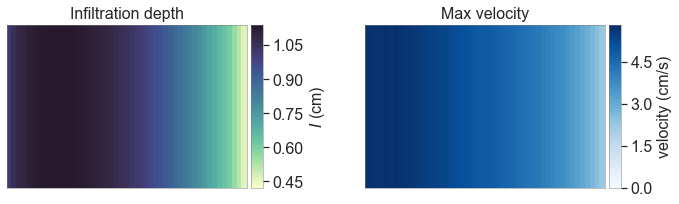

In [9]:

key = select_key.value
print(key)
sim = core.loc[key]
fig, axes = triptych(sim);


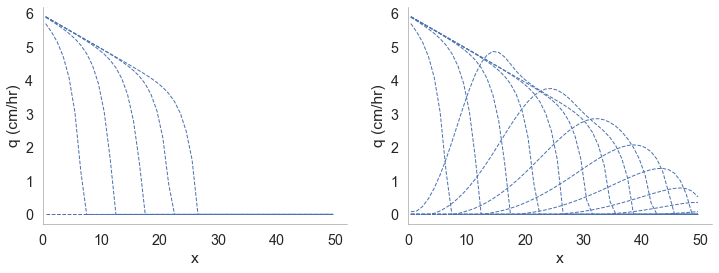

In [10]:
fig,axes = plt.subplots(1, 2, figsize = (12, 4))
fig, ax = plot_all_inflow(sim, t_f = sim.t_rain, freq = 10, label_axes=1, ax = axes[0])
fig, ax = plot_all_inflow(sim, t_f = sim.t_final, freq = 10, label_axes=1, ax = axes[1])

if "q1" in sim:
    axes[0].axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
    axes[1].axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")


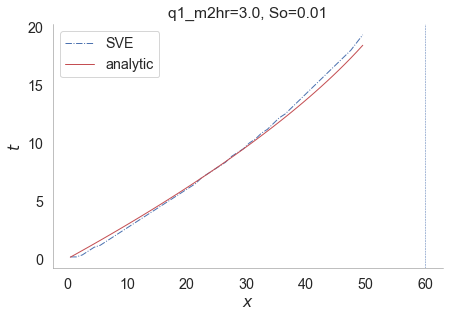

In [11]:
fig, ax  = plt.subplots(1, figsize= (7,4.5))
plt.subplots_adjust(wspace = 0.2)

x_front, t_front = compute_front(sim)
ax.plot(x_front, t_front/60.,'-.',label="SVE")

# x, t = forward_integrate(sim)    
# plt.plot( x, t/60., 'g-', ms = 5, label ="kinematic")
      
d, t = analytic_front(sim)

ax.plot(d, t/60.,'r',lw = 1, label="analytic")    
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title(sim.pretty)
ax.axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
# ax.set_xlim(15, 20)

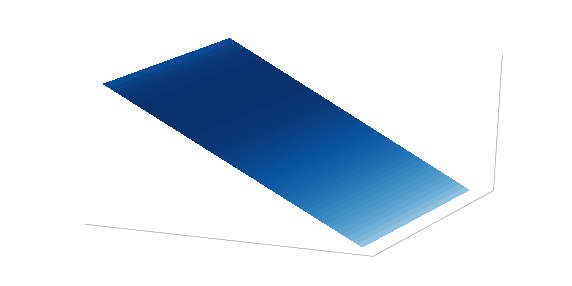

In [12]:
fig = plot_3D_infl(sim)

## Beginnings of analytic approach
Issues : 
1. characteristics cross
2. Combining rain BC (bare soil) with fixed flux (vegetated).  Fixable for constant infiltration rate, but still.

In [13]:
def analytic_front_specify(d, Ly, Q_inflow, KsV = 5, So = 0.01, alpha = 0.1, a= 2/3.):
    """
    Compute position and time for wetting front, using kinematic assumption
    and continuity
    
    Q_inflow : units m2/s
    
    """

    Kr = So**0.5/alpha #

    f = KsV/3.6e5  # Ksat (m/s)
    i =  - f # lateral inputs in m/s


    h_o = (Q_inflow/Kr)**(1./(a+1))


    t = (a+1)*(1/i*(i*d/Kr + Q_inflow/Kr)**(1/(a+1)) - h_o/i)/60.
    return d, t

### Make up some numbers

In [14]:
d = sim.xc.mean(0)
Ly = sim.Ly
So = sim.So
Lb = 20
alpha = sim.alpha
eta = sim.eta
a = sim.m
Kr = sim.So**sim.eta/sim.alpha

In [15]:
## Support, during the rising phase,
rain = 3*3.6e-5 # rain in m/s
t_in = np.arange(0.1, 5, 0.5)*60. # duration in s
q = Kr*rain**(a+1)*t_in**(a+1)

Text(0, 0.5, 't (min)')

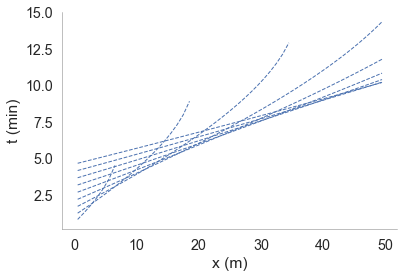

In [16]:
for i, inflow in enumerate(q):
    d, t = analytic_front_specify(d, Ly, inflow, KsV = 5, So = 0.05, alpha = 0.1, a= a)
    plt.plot(d, t + t_in[i]/60., 'b--')
plt.xlabel("x (m)")
plt.ylabel("t (min)")
